# Creation ontologies

Here, we create ontologies of the items contained in the scales using different approaches.

In the first approach, we use the embeddings given by the large language model directly. 
In the second approach, we compute an embedding of these embeddings so as to capture the relationships that are intrinsic to the set, instead of those of the corpus used to train the large language model. The idea is to use a diffusion kernel to clean up the similariy graph. These different approaches create alternative ontologies that are saved for evaluation.

In [44]:
import pandas as pd
import numpy as np
import phate
import scipy.spatial.distance as distance

# Here the scaled with the embeddings are loaded. Change the file to load
# embeddings from a different language model.
scales = pd.read_csv('scales_openAI.csv')

# select the rows of scales where the scaleID field is "NEO" or "PID"
scales = scales[scales['scaleID'].isin(['NEO', 'PID'])]

# form matrix of embeddings
mx = scales.embedding.apply(eval).to_list()
mx = np.asarray(mx)

# load scales data
data = pd.read_csv('scales_data.csv')

# select the columns of the dataframe data where the column names starts with "PID" or "NEO"
data = data[data.columns[data.columns.str.startswith('PID') | data.columns.str.startswith('NEO')]]

# form the correlation matrix of the scales data
corr_mx = data.corr().values
corr_values = distance.squareform(1 - corr_mx)

# extract the upper triangle of a matrix into a vector
def extract_upper_triangle(matrix):
    n = matrix.shape[0]
    return matrix[np.triu_indices(n, 1)]
corr_values = extract_upper_triangle(corr_mx)

The first approach is to use the language model ebeddings directly.

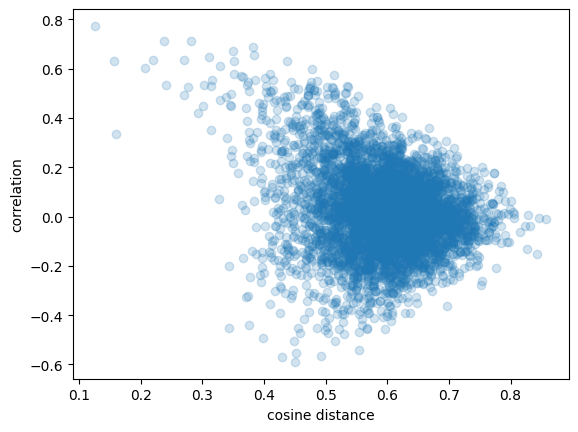

In [108]:

# Create a distance matrix from the data matrix mx
dist_values = distance.pdist(mx, metric='cosine')
dist_mx = distance.squareform(dist_values)

# Print a scatter plot of of dist_values and corr_values
import matplotlib.pyplot as plt
plt.scatter(dist_values, corr_values, alpha = 0.2)
plt.xlabel('cosine distance')
plt.ylabel('correlation')
plt.show()


We can see that items that have a small cosine distance (i.e. are similar) also have a high correlation. There are also some items with relatively small distance that have a negative correlation.

In the second approach, we use phate to estimate a diffusion kernel, and then we use the distances from that kernel to form the ontology.

In [ ]:
phate_operator = phate.PHATE(n_jobs = -2, gamma = -1, decay = 80, knn = 3, t = 1, n_components = 63, 
                             mds_dist='euclidean', mds = 'nonmetric', mds_solver = 'smacof') 
Y_phate = phate_operator.fit_transform(mx)

# Create a distance matrix from the data matrix mx
dist_values = distance.pdist(Y_phate, metric='euclidean')
dist_mx = distance.squareform(dist_values)


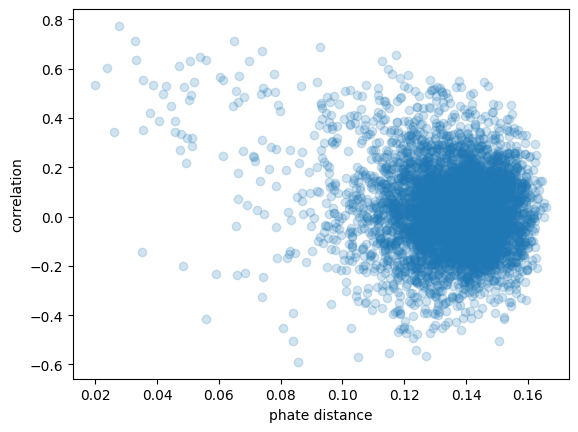

In [139]:

# Print a scatter plot of of dist_values and corr_values
import matplotlib.pyplot as plt
plt.scatter(dist_values, corr_values, alpha = 0.2)
plt.xlabel('phate distance')
plt.ylabel('correlation')
plt.show()

We obtain this result after modifying the default settings for phate. The most important changes are: 1. diffusion degrades the definition of distance and high correlation in data (hence, t = 1), 2. many dimensions are required (to do: use von Neumann entropy to automatically determine dimensions). Alpha decay, in contrast, improves performance (but not by much), as does a small neighbourhood.

This result appears to separate the items with high correlation a bit more from the buld. However, also a few items with no correlation are considered semantically similar.